# Example of DOV search methods for samples (monsters)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/DOV-Vlaanderen/pydov/master?filepath=docs%2Fnotebooks%2Fsearch_grondmonsters.ipynb)

## Use cases explained below
* Get samples in a bounding box
* Get samples in a bounding box based on specific properties
* Get sample based on fields not available in the standard output dataframe
* Get a boxplot with the depth distribution of samples with sampling instrument 'steekbuis'
* Finding the boreholes associated with the monsters and visualize results
* Adding the sampled object to the monster dataframe

In [1]:
import os

os.environ['PYDOV_BASE_URL'] = 'https://oefen.dov.vlaanderen.be/'

In [2]:
%matplotlib inline
import inspect, sys

In [3]:
# check pydov path
import pydov

## Get information about the datatype 'Monster'

In [4]:
from pydov.search.monster import MonsterSearch
monster = MonsterSearch()

A description is provided for the 'Monster' datatype:

In [5]:
print(monster.get_description())

Deze kaartlaag bevat monsters die gekoppeld zijn aan één of meerdere objecten: boringen, andere monsters, bodemobjecten en grondwaterfilters, filtergroepen of grondwaterinstallaties. Deze monsters zijn o.a. gekenmerkt door een diepte ten opzichte van het maaiveld, door de manier van staalname en de materiaalklasse. De geografische ligging (X en Y (mL72) en Z (mTAW)) nemen ze over van de gekoppelde object(en). Het type bemonsterd materiaal wordt beschreven in de 'Materiaalklasse'. Aan deze monsters kunnen er observaties gekoppeld zijn, zoals waarnemingen en resultaten van kwaliteitsanalyses in het laboratorium of in het veld en/of referenties naar bepaalde analyses. De gegevens van de monsters en bepaalde observaties kunnen worden geëxporteerd in een rapport.


The different fields that are available for objects of the 'Monster' datatype can be requested with the get_fields() method:

In [6]:
fields = monster.get_fields()

# print available fields
for f in fields.values():
    print(f['name'])

id
naam
pkey_monster
gekoppeld_aan
pkey_parents
materiaalklasse
diepte_van_m
diepte_tot_m
aantal_observaties
datum_monstername
monstersamenstelling
monstertype
bemonsteringsprocedure
bemonsteringsinstrument
bemonstering_door
actuele_opslaglocatie
opdracht
permkey_monster
geom


You can get more information of a field by requesting it from the fields dictionary:
* *name*: name of the field
* *definition*: definition of this field
* *cost*: currently this is either 1 or 10, depending on the datasource of the field. It is an indication of the expected time it will take to retrieve this field in the output dataframe.
* *notnull*: whether the field is mandatory or not
* *type*: datatype of the values of this field

Alternatively, you can list all the fields and their details by inspecting the `get_fields()` output or the search instance itself in a notebook:

In [7]:
monster

## Example use cases

### Get samples in a bounding box

Get data for all the samples that are geographically located within the bounds of the specified box.

The coordinates are in the Belgian Lambert72 (EPSG:31370) coordinate system and are given in the order of lower left x, lower left y, upper right x, upper right y.

In [8]:
from pydov.util.location import Within, Box

df = monster.search(location=Within(Box(122000, 187000, 124000, 189000, epsg=31370)))
df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,12,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,5.50,6.00,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek
1,https://oefen.dov.vlaanderen.be/data/monster/2...,16A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.00,7.12,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek
2,https://oefen.dov.vlaanderen.be/data/monster/2...,16B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.12,7.27,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek
3,https://oefen.dov.vlaanderen.be/data/monster/2...,16C,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.27,7.43,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek
4,https://oefen.dov.vlaanderen.be/data/monster/2...,16D,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.43,7.50,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek


The dataframe contains samples. The available data are flattened to represent unique attributes per row of the dataframe.

Using the *pkey_monster* field one can request the details of this sample in a webbrowser:
https://www.dov.vlaanderen.be/data/monster/*pkey_monster*

In [9]:
for pkey_monster in set(df.loc[df.naam == '16C'].pkey_monster):
    print(pkey_monster)

https://oefen.dov.vlaanderen.be/data/monster/2017-180446


### Get samples with specific properties

Next to querying samples based on their geographic location within a bounding box, we can also search for borehole samples matching a specific set of properties. For this we can build a query using a combination of the 'Monster' fields and operators provided by the WFS protocol.

A list of possible operators can be found below:

In [10]:
[i for i,j in inspect.getmembers(sys.modules['owslib.fes2'], inspect.isclass) if 'Property' in i]

['PropertyIsBetween',
 'PropertyIsEqualTo',
 'PropertyIsGreaterThan',
 'PropertyIsGreaterThanOrEqualTo',
 'PropertyIsLessThan',
 'PropertyIsLessThanOrEqualTo',
 'PropertyIsLike',
 'PropertyIsNotEqualTo',
 'PropertyIsNull',
 'SortProperty']

In this example we build a query using the *PropertyIsEqualTo* operator to find all samples where monstertype equals 'geroerd':

In [11]:
from owslib.fes2 import PropertyIsEqualTo

query = PropertyIsEqualTo(propertyname='monstertype',
                          literal='geroerd')
df = monster.search(query=query, max_features=10)

df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1996-06-01,79.0,79.0,geroerd,Enkelvoudig monster,NaN,[spoelboor],NaN
1,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1998-05-20,7.0,7.0,geroerd,Enkelvoudig monster,NaN,[avegaarbooras],NaN
2,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1999-05-06,10.5,10.5,geroerd,Enkelvoudig monster,NaN,[boor],NaN
3,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1981-05-17,0.1,0.1,geroerd,Enkelvoudig monster,NaN,[boor],NaN
4,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1963-06-01,11.0,12.0,geroerd,Enkelvoudig monster,NaN,[spoelboor],NaN


Once again we can use the *pkey_monster* as a permanent link to the information of these samples:

In [12]:
for pkey_monster in df['pkey_monster']:
    print(pkey_monster)

https://oefen.dov.vlaanderen.be/data/monster/2017-127061
https://oefen.dov.vlaanderen.be/data/monster/2017-127081
https://oefen.dov.vlaanderen.be/data/monster/2017-127099
https://oefen.dov.vlaanderen.be/data/monster/2017-131193
https://oefen.dov.vlaanderen.be/data/monster/2017-131408
https://oefen.dov.vlaanderen.be/data/monster/2017-141452
https://oefen.dov.vlaanderen.be/data/monster/2017-141453
https://oefen.dov.vlaanderen.be/data/monster/2017-135651
https://oefen.dov.vlaanderen.be/data/monster/2017-141454
https://oefen.dov.vlaanderen.be/data/monster/2017-141455


### Get samples in a bounding box based on specific properties

We can combine a query on attributes with a query on geographic location to get the samples within a bounding box that have specific properties.

The following example requests the samples with a depth greater than or equal to 15 meters within the given bounding box.

(Note that the datatype of the *literal* parameter should be a string, regardless of the datatype of this field in the output dataframe.)

In [13]:
from owslib.fes2 import PropertyIsGreaterThanOrEqualTo

query = PropertyIsGreaterThanOrEqualTo(
            propertyname='diepte_tot_m',
            literal='15')

df = monster.search(
    location=Within(Box(122000, 187000, 124000, 189000, epsg=31370)),
    query=query
    )

df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,39A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,17.00,17.37,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek
1,https://oefen.dov.vlaanderen.be/data/monster/2...,39B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,17.37,17.40,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek
2,https://oefen.dov.vlaanderen.be/data/monster/2...,N4A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2009-05-28,15.75,15.90,ongeroerd,Enkelvoudig monster,22475-1-2007,[steekbus],VO - Afdeling Geotechniek
3,https://oefen.dov.vlaanderen.be/data/monster/2...,N4B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2009-05-28,15.90,16.15,ongeroerd,Enkelvoudig monster,22475-1-2007,[steekbus],VO - Afdeling Geotechniek
4,https://oefen.dov.vlaanderen.be/data/monster/2...,N8,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2005-01-18,16.50,17.00,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek


### Get sample based on fields not available in the standard output dataframe

To keep the output dataframe size acceptable, not all available WFS fields are included in the standard output. However, one can use this information to select samples as illustrated below.

For example, make a selection of the monsters that are stored at the geotheek in Vilvoorde:

In [14]:
query = PropertyIsEqualTo(propertyname='actuele_opslaglocatie',
                               literal='Geotheek Vilvoorde')

df = monster.search(query=query, max_features = 10)
df.head()

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2007-01-30,1.2,1.50,geroerd,Enkelvoudig monster,NaN,[boor],NaN
1,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1969-11-05,1.0,1.24,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
2,https://oefen.dov.vlaanderen.be/data/monster/2...,2,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1972-12-01,3.2,3.20,geroerd,Enkelvoudig monster,NaN,[boor],NaN
3,https://oefen.dov.vlaanderen.be/data/monster/2...,7,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1971-03-29,7.5,7.68,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
4,https://oefen.dov.vlaanderen.be/data/monster/2...,CMON_P84df67e_laag_0_10_MG_2022,[https://oefen.dov.vlaanderen.be/data/bodemdie...,bodem,2022-02-16,0.0,0.10,geroerd,Mengmonster,csp,[steekguts30mm],VO - Instituut voor Natuur- en Bosonderzoek (I...


### Get sample with data from a subtype

There are different subtypes availeble within monster search: 'BemonsterdObject', 'Opslaglocatie', 'Monsterbehandeling'



In [15]:
from pydov.search.monster import MonsterSearch
from pydov.types.monster import Monster, Monsterbehandeling
from owslib.fes2 import PropertyIsLike

monster = MonsterSearch(
    objecttype=Monster.with_subtype(Monsterbehandeling))
query = PropertyIsLike(propertyname='pkey_monster', literal='%/2025-377219')
df = monster.search(query=query)
df.head()

[000/001] .
[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,monsterbehandeling_door,monsterbehandeling_datum,monsterbehandeling_tijdstip,monsterbehandeling_behandeling,monsterbehandeling_behandeling_waarde
0,https://oefen.dov.vlaanderen.be/data/monster/2...,M5,[https://oefen.dov.vlaanderen.be/data/boring/2...,strooisel,2025-01-07,5.0,5.5,ongeroerd,Mengmonster,22475-1-2021,"[edelmanboor, pulsboor]",GEOLAB,GEOLAB,NaN,NaN,Monstervoorbereiding door,GEOLAB
1,https://oefen.dov.vlaanderen.be/data/monster/2...,M5,[https://oefen.dov.vlaanderen.be/data/boring/2...,strooisel,2025-01-07,5.0,5.5,ongeroerd,Mengmonster,22475-1-2021,"[edelmanboor, pulsboor]",GEOLAB,NaN,NaN,NaN,Type breken vooraf opslag,Gebroken < 1 mm kaakbreker
2,https://oefen.dov.vlaanderen.be/data/monster/2...,M5,[https://oefen.dov.vlaanderen.be/data/boring/2...,strooisel,2025-01-07,5.0,5.5,ongeroerd,Mengmonster,22475-1-2021,"[edelmanboor, pulsboor]",GEOLAB,NaN,NaN,NaN,Type bewaring vooraf monstervoorbereiding,<-18°C (bevroren)
3,https://oefen.dov.vlaanderen.be/data/monster/2...,M5,[https://oefen.dov.vlaanderen.be/data/boring/2...,strooisel,2025-01-07,5.0,5.5,ongeroerd,Mengmonster,22475-1-2021,"[edelmanboor, pulsboor]",GEOLAB,NaN,NaN,NaN,Type droging vooraf opslag,Luchtgedroogd
4,https://oefen.dov.vlaanderen.be/data/monster/2...,M5,[https://oefen.dov.vlaanderen.be/data/boring/2...,strooisel,2025-01-07,5.0,5.5,ongeroerd,Mengmonster,22475-1-2021,"[edelmanboor, pulsboor]",GEOLAB,NaN,NaN,NaN,Type malen vooraf opslag,Niet gemalen


### Get a boxplot with the depth distribution of samples with sampling instrument 'steekbus'

In [16]:
from pydov.util.query import PropertyLikeList

monster = MonsterSearch()

query = PropertyLikeList(propertyname='bemonsteringsinstrument',
                         lst=['steekbus'])

df = monster.search(query=query, return_fields=[
    'diepte_van_m', 'diepte_tot_m'
])


[000/001] .


In [17]:
df.describe()

,diepte_van_m,diepte_tot_m
count,31677.000000,31700.000000
mean,6.752202,7.083135
std,7.105127,7.144072
min,0.000000,0.100000
25%,2.000000,2.290000
50%,4.390000,4.650000
75%,9.000000,9.200000
max,60.000000,60.300000


Text(0.5, 1.0, "Depth distribution samples with sampling instrument 'steekbus'")

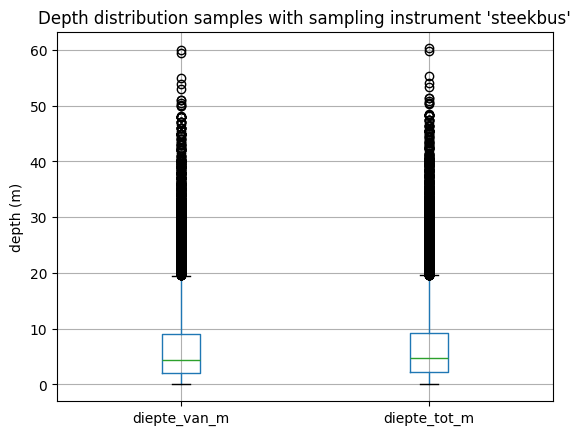

In [18]:
ax = df[df.diepte_tot_m != 0].boxplot()
ax.set_ylabel("depth (m)")
ax.set_title("Depth distribution samples with sampling instrument 'steekbus'")

## Finding related data

### Finding boreholes associated with samples

To find the boreholes based on a given dataframe with samples, you can use the Join query operator:

In [19]:
from pydov.search.monster import MonsterSearch
from pydov.search.boring import BoringSearch

from pydov.util.query import Join

monster_search = MonsterSearch()
boring_search = BoringSearch()

df_monsters = monster_search.search(max_features=100)
df_monsters

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1996-06-01,79.0,79.0,geroerd,Enkelvoudig monster,NaN,[spoelboor],NaN
1,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1998-05-20,7.0,7.0,geroerd,Enkelvoudig monster,NaN,[avegaarbooras],NaN
2,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1999-05-06,10.5,10.5,geroerd,Enkelvoudig monster,NaN,[boor],NaN
3,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1980-01-01,288.8,288.8,ongeroerd,Enkelvoudig monster,NaN,[buis],NaN
4,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1981-05-17,0.1,0.1,geroerd,Enkelvoudig monster,NaN,[boor],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0602,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,2006-02-23,NaN,6.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV
96,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0602,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,2006-02-22,NaN,3.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV
97,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0603,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,2006-08-25,NaN,6.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV
98,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0603,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,2006-08-25,NaN,3.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV


In [20]:
df_boringen = boring_search.search(
    query=Join(df_monsters, on='pkey_boring', using='pkey_parents'))
df_boringen

[000/001] .
[000/009] .........


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://oefen.dov.vlaanderen.be/data/boring/19...,kb26d63e-B3,234942.00,189926.00,74.00,74.00,As,0.0,649.50,1901-01-01,onbekend,False,0.0,649.50,onbekend
1,https://oefen.dov.vlaanderen.be/data/boring/19...,kb26d78e-B249,236820.00,181175.00,90.50,90.50,Zutendaal,0.0,200.70,1996-06-01,Peeters-Ramsel,True,0.0,200.70,spoelboring
2,https://oefen.dov.vlaanderen.be/data/boring/19...,kb17d32w-B380,214069.50,216345.40,47.00,47.00,Lommel,0.0,20.00,1981-05-17,onbekend,False,0.0,20.00,onbekend
3,https://oefen.dov.vlaanderen.be/data/boring/19...,kb32d103w-B110,165215.00,161534.00,80.00,80.00,Overijse,0.0,56.00,1963-06-01,Smet - Dessel,False,0.0,56.00,spoelboring
4,https://oefen.dov.vlaanderen.be/data/boring/20...,B/000/00/2,28554.55,194470.43,3.66,3.66,Veurne,0.0,3.20,2003-04-08,BVMO,False,0.0,3.20,avegaarboring
5,https://oefen.dov.vlaanderen.be/data/boring/19...,kb23d73w-B386,153903.00,178252.00,13.00,13.00,Machelen,0.0,36.50,1999-05-06,GEOLAB,False,0.0,36.50,droge boring
6,https://oefen.dov.vlaanderen.be/data/boring/19...,GEO-98/060-B1,160032.90,175678.80,NaN,59.97,NaN,0.0,7.00,1998-05-20,MVG - Afdeling Geotechniek,False,0.0,7.00,ramkernboring
7,https://oefen.dov.vlaanderen.be/data/boring/19...,kb5d11e-B287,78776.00,226370.00,4.90,4.90,Knokke-Heist,0.0,440.90,1980-01-01,Smet - Dessel,True,0.0,440.90,gestoken boring
8,https://oefen.dov.vlaanderen.be/data/boring/19...,kb32d90w-B1117,181406.00,172961.00,66.00,66.00,Lubbeek,0.0,46.95,1964-01-01,onbekend,False,0.0,46.95,onbekend


### Finding samples associated with boreholes

To find the samples based on a given dataframe with boreholes, you can use the `FuzzyJoin` query operator. This will make sure you get all the samples which are (at least partly) linked to one of the boreholes:

In [21]:
from pydov.search.monster import MonsterSearch
from pydov.search.boring import BoringSearch

from pydov.util.query import FuzzyJoin

monster_search = MonsterSearch()
boring_search = BoringSearch()

df_boringen = boring_search.search(max_features=100)
df_boringen

[000/001] .
[000/100] ..................................................
[050/100] ..................................................


,pkey_boring,boornummer,x,y,mv_mtaw,start_boring_mtaw,gemeente,diepte_boring_van,diepte_boring_tot,datum_aanvang,uitvoerder,boorgatmeting,diepte_methode_van,diepte_methode_tot,boormethode
0,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B574,92424.0,170752.0,40.00,40.00,Wortegem-Petegem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend
1,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B575,92296.0,170885.0,46.00,46.00,Wortegem-Petegem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend
2,https://oefen.dov.vlaanderen.be/data/boring/19...,kb22d55e-B1037,108890.0,188690.0,14.31,14.31,Melle,0.0,15.0,1945-01-01,De Meyer L.-Gent,False,0.0,15.0,droge boring
3,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B576,92243.0,170939.0,47.50,47.50,Wortegem-Petegem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend
4,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B577,92475.0,171088.0,39.00,39.00,Wortegem-Petegem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B650,90085.0,176728.0,61.00,61.00,Kruishoutem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend
101,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B651,90668.0,176436.0,64.00,64.00,Kruishoutem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend
102,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B652,90870.0,176275.0,68.00,68.00,Kruishoutem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend
103,https://oefen.dov.vlaanderen.be/data/boring/20...,kb29d84e-B653,90760.0,176102.0,70.00,70.00,Kruishoutem,0.0,0.0,NaN,onbekend,False,0.0,0.0,onbekend


In [22]:
df_monsters = monster_search.search(
    query=FuzzyJoin(df_boringen, on='pkey_parents', using='pkey_boring'))
df_monsters

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door
0,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-06-28,0.5,0.57,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
1,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-07-06,0.5,0.74,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
2,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-07-12,0.5,0.66,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
3,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-07-14,0.5,0.70,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
4,https://oefen.dov.vlaanderen.be/data/monster/2...,1,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-08-08,1.0,1.33,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
5,https://oefen.dov.vlaanderen.be/data/monster/2...,2,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-06-28,2.0,2.27,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
6,https://oefen.dov.vlaanderen.be/data/monster/2...,2,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-07-06,7.0,7.18,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
7,https://oefen.dov.vlaanderen.be/data/monster/2...,2,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-07-14,3.0,3.29,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
8,https://oefen.dov.vlaanderen.be/data/monster/2...,2,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-08-08,3.0,3.32,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica
9,https://oefen.dov.vlaanderen.be/data/monster/2...,3,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,1966-06-28,3.5,3.78,ongeroerd,Enkelvoudig monster,NaN,[steekbus],Rijksinstituut voor Grondmechanica


## Adding the sampled object to the monster dataframe

The default dataframe of the Monster datatype doesn't contains information about the 'sampled object' by default. This can be added to the dataframe as its subtype.

You can find which extra subtypes are available for a certain type with the `get_subtypes` method:

In [23]:
from pydov.types.monster import Monster

Monster.get_subtypes()

{'BemonsterdObject': {'name': 'BemonsterdObject',
  'class': pydov.types.monster.BemonsterdObject,
  'definition': 'Subtype listing the sampled object(s) of the sample. It has the following fields: bemonsterd_object_type, bemonsterd_object_naam, bemonsterd_object_permkey.'},
 'Monsterbehandeling': {'name': 'Monsterbehandeling',
  'class': pydov.types.monster.Monsterbehandeling,
  'definition': 'Subtype containing fields about the\ntreatment of the sample. It has the following fields: monsterbehandeling_door, monsterbehandeling_datum, monsterbehandeling_tijdstip, monsterbehandeling_behandeling, monsterbehandeling_behandeling_waarde.'},
 'Opslaglocatie': {'name': 'Opslaglocatie',
  'class': pydov.types.monster.Opslaglocatie,
  'definition': 'Subtype listing the storage location(s) of the sample. It has the following fields: opslaglocatie_naam, opslaglocatie_van, opslaglocatie_tot.'}}

To get the details about the sampled objects, we can instantiate the search class with the `BemonsterdObject` subtype:

In [24]:
from pydov.types.monster import BemonsterdObject

monster_search = MonsterSearch(
    objecttype=Monster.with_subtype(BemonsterdObject)
)

When we now request information about the fields, this will include the extra fields from the subtype:

In [25]:
monster_search.get_fields()['bemonsterd_object_permkey']

{'name': 'bemonsterd_object_permkey', 'type': 'string', 'list': False, 'definition': 'Een unieke DOV identifier in de vorm van een permkey.', 'notnull': False, 'query': False, 'cost': 10}

And when we query the data, the extra fields will be part of the resulting dataframe:

In [26]:
df = monster_search.search(location=Within(Box(122000, 187000, 124000, 189000, epsg=31370)), max_features = 10)
df.head()

[000/001] .
[000/010] ..........


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,bemonsterd_object_type,bemonsterd_object_naam,bemonsterd_object_permkey
0,https://oefen.dov.vlaanderen.be/data/monster/2...,12,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,5.50,6.00,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
1,https://oefen.dov.vlaanderen.be/data/monster/2...,16A,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.00,7.12,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
2,https://oefen.dov.vlaanderen.be/data/monster/2...,16B,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.12,7.27,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
3,https://oefen.dov.vlaanderen.be/data/monster/2...,16C,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.27,7.43,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282
4,https://oefen.dov.vlaanderen.be/data/monster/2...,16D,[https://oefen.dov.vlaanderen.be/data/boring/2...,sediment,2002-03-04,7.43,7.50,ongeroerd,Enkelvoudig monster,NaN,[steekbus],MVG - Afdeling Geotechniek,BORING,GEO-02/028-B5,2002-003282


Mind that one sample can originate from multiple 'sampled objects', so it's possible for one sample to be split into multiple rows. Also, since we are now requesting fields from XML, querying will be significantly slower than before.

## Get more details about a sample

To get more details about a sample than is available in the default dataframe, you can add an extra fieldset containing extra details.

You can find which extra fieldsets are available for a certain type with the `get_fieldsets` method:

In [27]:
from pydov.types.monster import Monster

Monster.get_fieldsets()

{'MonsterDetails': {'name': 'MonsterDetails',
  'class': pydov.types.monster.MonsterDetails,
  'definition': 'Fieldset containing fields with extra\ndetails about the sample.\n It has the following fields: tijdstip_monstername.'}}

In this case, the fieldset `MonsterDetails` is available, which will add the extra field `tijdstip_monstername`.

To use it, we can add the extra fields from the fieldset when instantiating our search instance:

In [28]:
from pydov.search.monster import MonsterSearch
from pydov.types.monster import Monster, MonsterDetails

monster_search = MonsterSearch(
    objecttype=Monster.with_extra_fields(MonsterDetails))

When we now request information about the fields, this will include the extra fields from the fieldset:

In [29]:
monster_search.get_fields()['tijdstip_monstername']

{'name': 'tijdstip_monstername', 'type': 'string', 'list': False, 'definition': 'Tijdstip waarop het monster werd verkregen uit het bemonsterdObject.', 'notnull': False, 'query': False, 'cost': 10}

And when we query the data, the extra details will be part of the resulting dataframe:

In [30]:
from owslib.fes2 import PropertyIsLike

monster_search.search(
    query=PropertyIsLike(
        'pkey_monster', '%/2022-324252')
)

[000/001] .
[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,datum_monstername,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,tijdstip_monstername
0,https://oefen.dov.vlaanderen.be/data/monster/2...,CMON_Pae34829_laag_0_10_MG_2022,NaN,bodem,2022-01-19,0.0,0.1,geroerd,Mengmonster,csp,[steekguts30mm],"VO - Instituut voor Landbouw-, Visserij- en Vo...",10:00:00


## Visualise results on a map

Using Folium, we can display the results of our search on a map.

In [31]:
# import the necessary modules (not included in the requirements of pydov!)
import folium
import geopandas as gpd

In [32]:
from pydov.search.monster import MonsterSearch
from pydov.types.monster import Monster

from pydov.search.fields import GeometryReturnField

ms = MonsterSearch()

return_fields = Monster.get_field_names()
return_fields.remove('datum_monstername')
return_fields.append(GeometryReturnField('geom', 31370))

df = ms.search(max_features=100, return_fields=return_fields)
df

[000/001] .


,pkey_monster,naam,pkey_parents,materiaalklasse,diepte_van_m,diepte_tot_m,monstertype,monstersamenstelling,bemonsteringsprocedure,bemonsteringsinstrument,bemonstering_door,geom
0,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,79.0,79.0,geroerd,Enkelvoudig monster,NaN,[spoelboor],NaN,POINT (236820 181175)
1,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,7.0,7.0,geroerd,Enkelvoudig monster,NaN,[avegaarbooras],NaN,POINT (160032.9 175678.8)
2,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,10.5,10.5,geroerd,Enkelvoudig monster,NaN,[boor],NaN,POINT (153903 178252)
3,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,288.8,288.8,ongeroerd,Enkelvoudig monster,NaN,[buis],NaN,POINT (78776 226370)
4,https://oefen.dov.vlaanderen.be/data/monster/2...,0,[https://oefen.dov.vlaanderen.be/data/boring/1...,sediment,0.1,0.1,geroerd,Enkelvoudig monster,NaN,[boor],NaN,POINT (214069.5 216345.4)
...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0602,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,NaN,6.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV,POINT (29001.35 187051.01)
96,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0602,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,NaN,3.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV,POINT (29001.35 187051.01)
97,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0603,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,NaN,6.5,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV,POINT (29001.35 187051.01)
98,https://oefen.dov.vlaanderen.be/data/monster/2...,000/32/2/M0603,[https://oefen.dov.vlaanderen.be/data/filter/2...,grondwater,NaN,3.0,vloeistof,Enkelvoudig monster,NaN,[pomp],Eurofins Envirotox NV,POINT (29001.35 187051.01)


In [33]:
geo_df = gpd.GeoDataFrame(df, geometry='geom', crs='EPSG:31370')
popup = folium.GeoJsonPopup(fields=["naam", "diepte_van_m", "diepte_tot_m", 'pkey_parents'])
geo_json = folium.GeoJson(data=geo_df, popup=popup)

In [34]:
# initialize the Folium map on the centre of the selected locations, play with the zoom until ok
fmap = folium.Map(zoom_start=12)
geo_json.add_to(fmap)

fmap.fit_bounds(fmap.get_bounds())
fmap